6장 코드

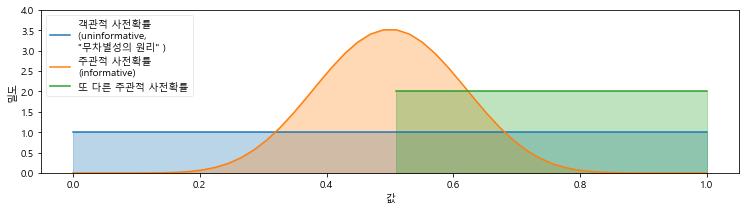

In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib

matplotlib.rc('font', family='Malgun Gothic')  # 그림 한글 폰트 지정, 맑은 고딕

figsize(12.5, 3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0, 1)
y1, y2 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 10, 10)

p = plt.plot(x, y1,
    label='객관적 사전확률\n(uninformative, \n"무차별성의 원리" )')
plt.fill_between(x, 0, y1, color=p[0].get_color(), alpha=0.3)

p = plt.plot(x, y2,
    label="주관적 사전확률\n(informative)")
plt.fill_between(x, 0, y2, color=p[0].get_color(), alpha=0.3)

p = plt.plot(x[25:], 2 * np.ones(25), label="또 다른 주관적 사전확률")
plt.fill_between(x[25:], 0, 2, color=p[0].get_color(), alpha=0.3)

plt.ylim(0, 4)
plt.ylim(0, 4)
leg = plt.legend(loc="upper left")
leg.get_frame().set_alpha(0.4)
plt.xlabel("값")
plt.ylabel("밀도")
#plt.title("미지의 확률에 대한 객관적 사전확률분포와 주관적 사전확률분포 비교");

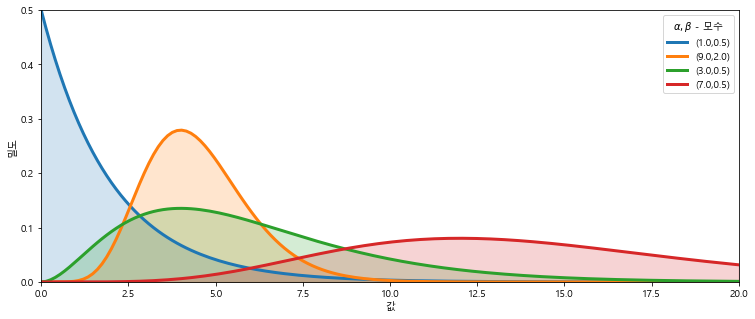

In [2]:
figsize(12.5, 5)
gamma = stats.gamma
parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001, 20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1./beta)
    lines = plt.plot(x, y, label="(%.1f,%.1f)"%(alpha,beta), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - 모수")
plt.xlabel("값")
plt.ylabel("밀도")
#plt.title("$alpha$ 와 $beta$ 의 여러 값에 대한 감마분포");

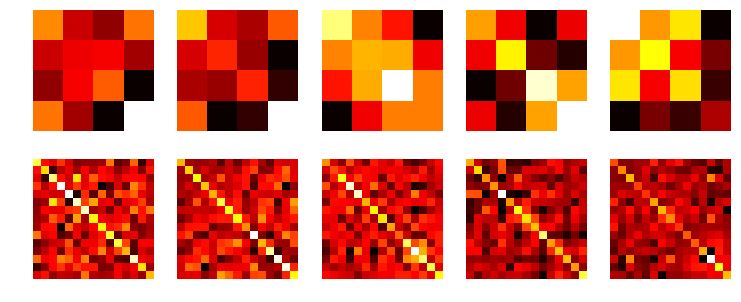

In [3]:
import pymc as pm
n = 4
hyperparameter = np.eye(n)
for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(pm.rwishart(n+1, hyperparameter), interpolation="none",
    cmap=plt.cm.hot)
    ax.axis("off")
n = 15
hyperparameter = 10*np.eye(n)
for i in range(5, 10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(pm.rwishart(n+1, hyperparameter), interpolation="none",
    cmap=plt.cm.hot)
    ax.axis("off")    
#plt.suptitle("위샤트분포의 4*4(상단)와 15*15(하단)의 랜덤행렬");


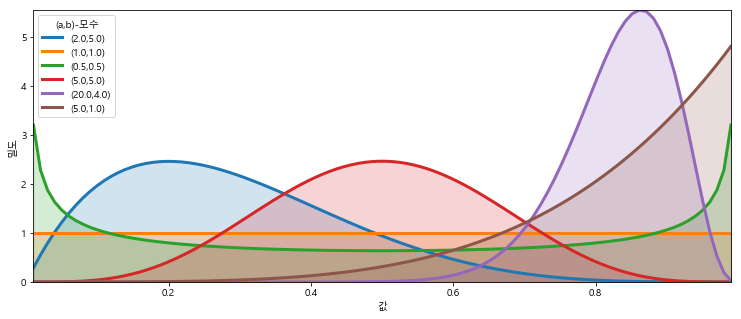

In [4]:
figsize(12.5, 5)
params = [(2,5), (1,1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]
x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label="(%.1f,%.1f)"%(a,b), lw = 3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.ylim(0)
plt.legend(loc='upper left', title="(a,b)-모수")
plt.xlabel('값')
plt.ylabel('밀도')
#plt.title("$alpha$ 와 $beta$의 여러 값에 대한 베타분포");

In [5]:
from pymc import rbeta


class Bandits(object):

    """
    이 클래스는 N개의 밴디트 머신이다.
    인수:
        p_array: Numpy 확률배열(0이상 1이하)
    메서드:
        pull( i ): i번째 밴디트를 당긴 결과 0 또는 1을 돌려준다
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def pull(self, i):
        # i is which arm to pull
        # i는 잡아 당길 밴디트머신
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


class BayesianStrategy(object):

    """
    MAB(Multi-Armed Bandit) 문제를 풀기 위한 온라인 학습전략 구현
    인수:
        bandits: Bandit클래스
    메서드:
        sample_bandits(n): n번 시도에 대한 표본과 훈련
    어트리뷰트:
        N: 표본의 누적수
        choices: 과거 선택 배열 (N,)
        bb_score: 과거 점수 배열 (N,)
    """
    def __init__(self, bandits):

        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    def sample_bandits(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the bandits's priors, and select the largest sample
            # 밴디트 사전확률분포 표본추출하고 가장 큰 표본을 고른다
            choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen bandit
            # 선택한 밴디트를 표본추출한다
            result = self.bandits.pull(choice)

            # update priors and score
            # 사전확률분포를 업데이트 하고 점수 부여
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [6]:

figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)


def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    # 작도함수
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="기본확률: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("%d 번 시도 이후 사후확률분포" % bayesian_strategy.N +
                  ""* (bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

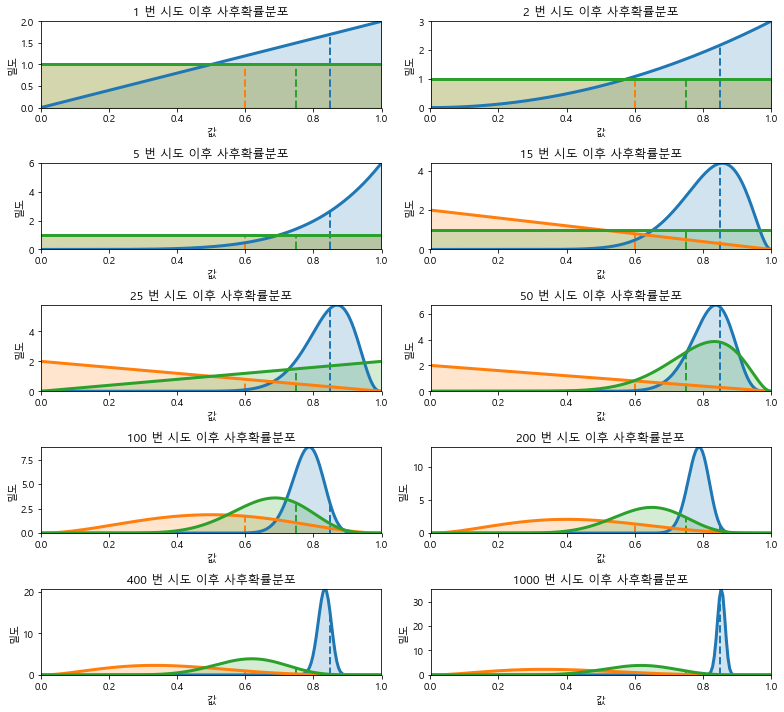

In [7]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    # plt.legend()
    plt.autoscale(tight=True)
    plt.xlabel('값')
    plt.ylabel('밀도')
#plt.title("여러 차례 시도 후 각 기계에 대한 추론의 사후확률분포")
plt.tight_layout()

In [8]:

from IPython.core.display import HTML

# try executing the below command twice if the first time doesn't work
# 아래 명령이 작동하지 않으면 다시 한번 명령을 실행해보도록 한다
HTML(filename="BanditsD3.html")

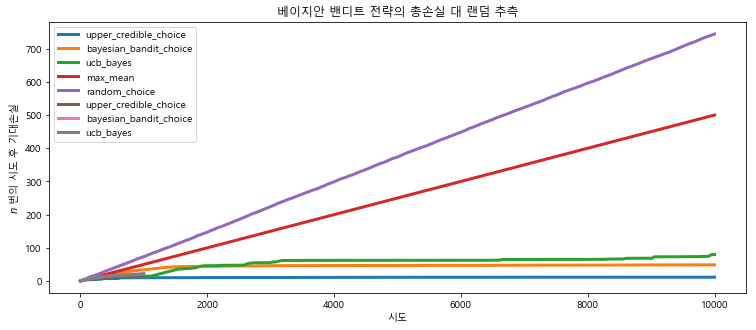

In [9]:
figsize(12.5, 5)
from other_strats import GeneralBanditStrat, bayesian_bandit_choice, max_mean, lower_credible_choice, \
                         upper_credible_choice, random_choice, ucb_bayes, Bandits

# define a harder problem
# 더 어려운 문제 정의
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

# define regret
# 손실 정의

def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

# create new strategies
# 새 전략 생성
strategies = [upper_credible_choice,
              bayesian_bandit_choice,
              ucb_bayes,
              max_mean,
              random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))
# train 10000 times
# 10,000번 훈련
for strat in algos:
    strat.sample_bandits(10000)

#test and plot
# 테스트하고 작도한다
for i, strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label=strategies[i].__name__, lw=3)

#plt.title("베이지안 밴디트 전략의 총손실 대 랜덤 추측")
plt.xlabel("시도")
plt.ylabel("$n$ 번 시도 후 손실");
plt.legend(loc="upper left");

# this can be slow, so I recommend NOT running it.
# 다음 이하는 시간이 걸릴 수 있다. 그래서 실행을 권하진 않는다
trials = 200
expected_total_regret = np.zeros((1000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(1000)
        _regret = regret(hidden_prob, general_strat.choices)
        expected_total_regret[:, i_strat] += _regret

    plt.plot(expected_total_regret[:, i_strat] / trials, lw=3, label=strat.__name__)

#plt.title("MAB(Multi-armed Bandit)전략의 기대손실")
plt.xlabel("시도")
plt.ylabel("$n$ 번의 시도 후 기대손실");
plt.legend(loc="upper left");

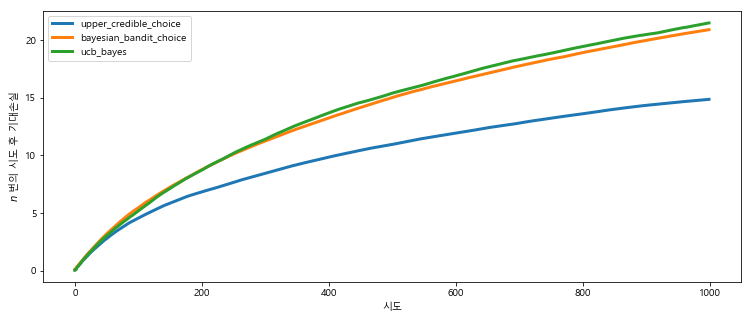

In [10]:
# this can be slow, so I recommend NOT running it.
# 아래는 시간이 걸릴 수 있어 실행하는 걸 권하진 않는다
trials = 200
expected_total_regret = np.zeros((1000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(1000)
        _regret = regret(hidden_prob, general_strat.choices)
        expected_total_regret[:, i_strat] += _regret

    plt.plot(expected_total_regret[:, i_strat] / trials, lw=3, label=strat.__name__)

#plt.title("MAB(Multi-armed Bandit)전략의 기대손실")
plt.xlabel("시도")
plt.ylabel("$n$ 번의 시도 후 기대손실");
plt.legend(loc="upper left");

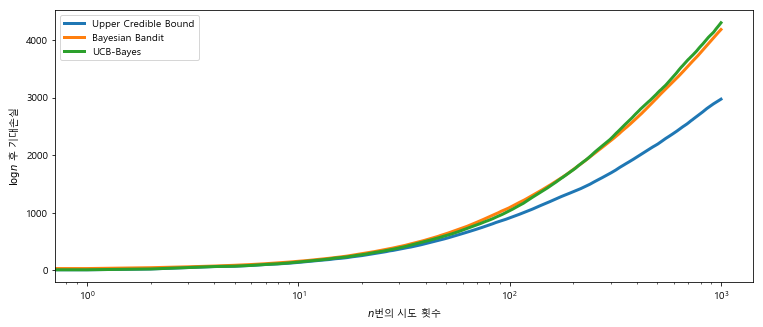

In [11]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0, 1, 2]], lw=3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3],
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
           loc="upper left")

plt.xlabel("$n$번의 시도 횟수")
plt.ylabel("$\log{n}$ 후 기대손실")
#plt.title("여러 MAB(Multi-armed Bandit)전략의 기대손실의 로그 변환");

[ 0.04647008  0.09786828  0.08493212  0.22686331  0.1297903   0.03985958
  0.01141066  0.06918034  0.14502113  0.14721859  0.04636526  0.10623119
  0.05328573  0.01748078  0.10730565  0.02231055  0.02475013  0.06923286
  0.07190686  0.03345858  0.08384849  0.07124308  0.13023224  0.1096078
  0.06610746  0.09429226  0.03185204  0.03642279  0.0042892   0.29584459
  0.10566908  0.11679164  0.16595385  0.06822148  0.02268883]


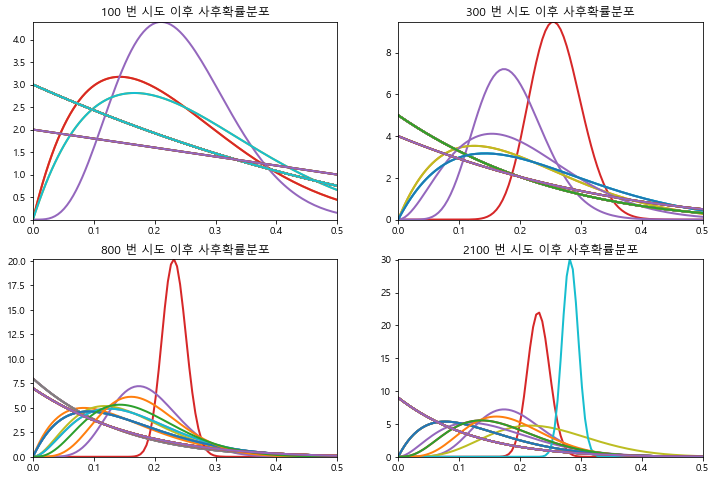

In [12]:
figsize(12.0, 8)
beta = stats.beta
hidden_prob = beta.rvs(1,13, size=35)
print (hidden_prob)
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)
for j,i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j+1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw = 2, alpha = 0.0,
        plt_vlines=False)
    plt.xlim(0, 0.5)

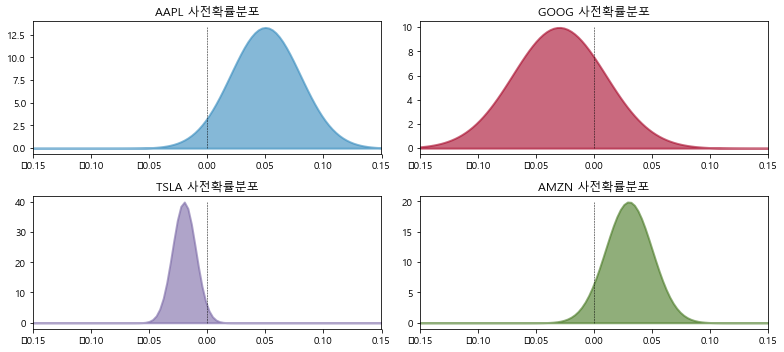

In [13]:
figsize(11., 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL": (0.05, 0.03),
                       "GOOG": (-0.03, 0.04),
                       "TSLA": (-0.02, 0.01),
                       "AMZN": (0.03, 0.02),
                       }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i + 1)
    y = normal.pdf(x, params[0], scale=params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color=colors[i], linewidth=2,
                     edgecolor=colors[i], alpha=0.6)
    plt.title(name + " 사전확률분포")
    plt.vlines(0, 0, y.max(), "k", "--", linewidth=0.5)
    plt.xlim(-0.15, 0.15)

plt.tight_layout()
#plt.suptitle("여러 상장주식의 수익률에 대한 사전확률분포")

In [14]:
import pymc as pm

n_observations = 100  # 가장 최근 100일만 다룬다 # we will truncate the the most recent 100 days.

prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

inv_cov_matrix = pm.Wishart("inv_cov_matrix", n_observations, np.diag(prior_std ** 2))
mu = pm.Normal("returns", prior_mu, 1, size=4)

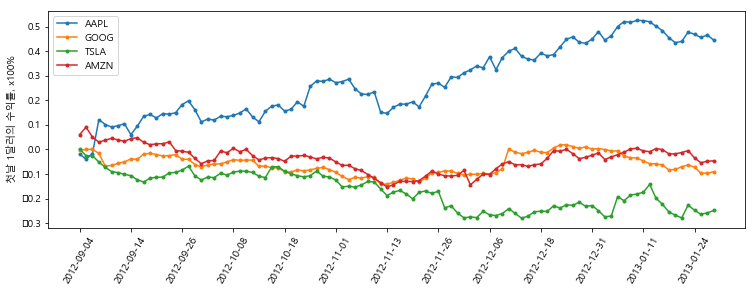

In [15]:
# I wish I could have used Pandas as a prereq for this book, but oh well.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
import datetime

matplotlib.rc('font', family='Malgun Gothic')  # 그림 한글 폰트 지정, 맑은 고딕

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = "2015-04-27"
startdate = "2012-09-01"

stock_closes = {}
stock_returns = {}
n_observations = 100

for stock in stocks:
    df = pd.read_csv('data/%s.csv' % stock, names=['Date','Open','High','Low','Close','Adj Close','Volume'], header=0)
    x = np.array(df)    
    stock_closes[stock] = x[:,5].astype(float)   

# create returns:
# 수익률 계산
for stock in stocks:
    _previous_day = np.roll(stock_closes[stock], -1)
    stock_returns[stock] = ((stock_closes[stock] - _previous_day) / _previous_day)[:n_observations]

dates = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations + 1, 0]))

figsize(12.5, 4)

for _stock, _returns in stock_returns.items():
    p = plt.plot((1 + _returns)[::-1].cumprod() - 1, '-o', label="%s" % _stock,
                 markersize=4, markeredgecolor="none")

plt.xticks(np.arange(100)[::8],
    list(map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::8])),
    rotation=60);


plt.legend(loc="upper left")
#plt.title("주식수익률")
plt.ylabel("첫날 1달러의 수익률, x100%");
plt.show()


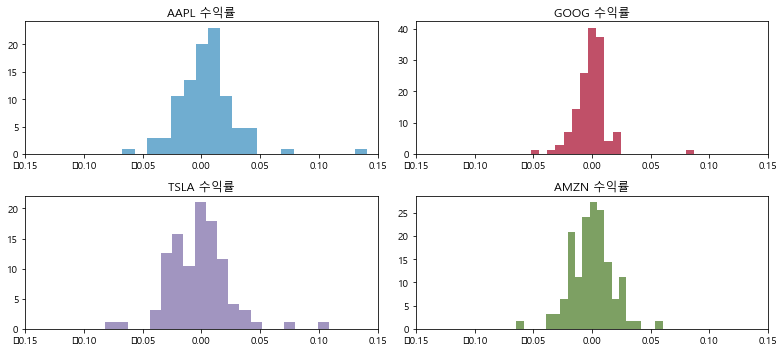

In [16]:
figsize(11.0, 5)
returns = np.zeros((n_observations, 4))
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]
for i, (_stock, _returns) in enumerate(stock_returns.items()):
    returns[:, i] = _returns
    plt.subplot(2, 2, i+1)
    plt.hist(_returns, bins=20,
             normed=True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    plt.title(_stock + " 수익률")
    plt.xlim(-0.15, 0.15)

plt.tight_layout()
#plt.suptitle("일간수익률 히스토그램", size=14);

In [17]:
obs = pm.MvNormal("observed returns", mu, inv_cov_matrix, observed=True, value=returns)

model = pm.Model([obs, mu, inv_cov_matrix])
mcmc = pm.MCMC()

mcmc.sample(150000, 100000, 3)

C:\Users\wh\Anaconda3\lib\site-packages\pymc\Model.py:94: UserWarning: The MCMC() syntax is deprecated. Please pass in nodes explicitly via M = MCMC(input).
  'The MCMC() syntax is deprecated. Please pass in nodes explicitly via M = MCMC(input).')
C:\Users\wh\Anaconda3\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 150000 of 150000 complete in 98.9 sec

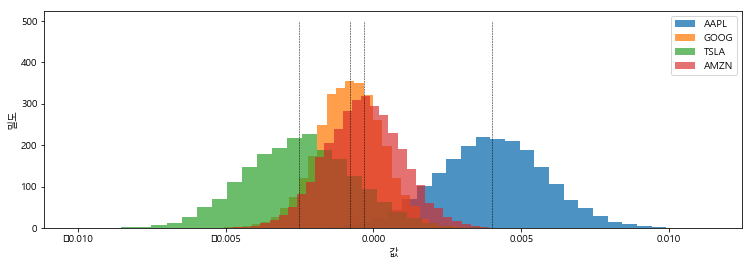

In [18]:
figsize(12.5, 4)

# examine the mean return first.
# 우선 평균수익률을 확인한다
mu_samples = mcmc.trace("returns")[:]

for i in range(4):
    plt.hist(mu_samples[:, i], alpha=0.8 - 0.05 * i, bins=30,
             histtype="stepfilled", normed=True,
             label="%s" % list(stock_returns.keys())[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth=.5)

#plt.title("일간 수익률 $\mu$의 사후확률분포")
plt.xlabel('값')
plt.ylabel('밀도')
plt.legend();

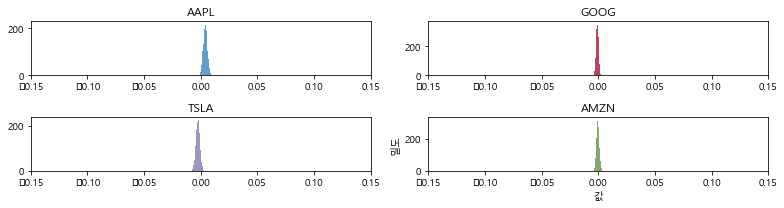

In [19]:
figsize(11.0, 3)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(mu_samples[:, i], alpha=0.8 - 0.05 * i, bins=30,
             histtype="stepfilled", normed=True, color=colors[i],
             label="%s" % list(stock_returns.keys())[i])
    plt.title("%s" % list(stock_returns.keys())[i])
    plt.xlim(-0.15, 0.15)

#plt.suptitle("일간 수익률의 사후확률분포")
plt.xlabel('값')
plt.ylabel('밀도')
plt.tight_layout()

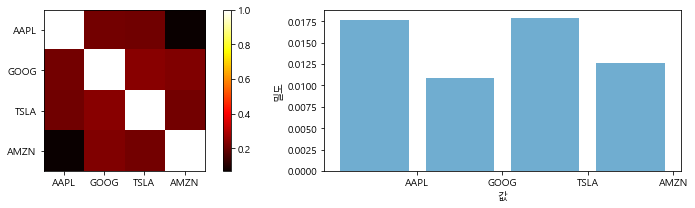

In [20]:
inv_cov_samples = mcmc.trace("inv_cov_matrix")[:]
mean_covariance_matrix = np.linalg.inv(inv_cov_samples.mean(axis=0))
def cov2corr(A):
    """
    covariance matrix to correlation matrix
    """
    """
    공분산행렬을 상관행렬로 변환
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    return A
plt.subplot(1,2,1)
plt.imshow(cov2corr(mean_covariance_matrix), interpolation="none",
    cmap = plt.cm.hot)
plt.xticks(np.arange(4), stock_returns.keys())
plt.yticks(np.arange(4), stock_returns.keys())
plt.colorbar(orientation="vertical")
#plt.title("(평균 사후확률분포) 상관관계 행렬")
plt.subplot(1,2,2)
plt.bar(np.arange(4), np.sqrt(np.diag(mean_covariance_matrix)),
    color="#348ABD", alpha=0.7)
plt.xticks(np.arange(4) + 0.5, stock_returns.keys());
#plt.title("(평균 사후확률분포) 수익률의 분산")
plt.xlabel('값')
plt.ylabel('밀도')
plt.tight_layout()
#plt.suptitle("왼쪽: (평균 사후확률분포) 상관관계 행렬, 오른쪽: (평균 사후확률분포) 수익률의 분산");

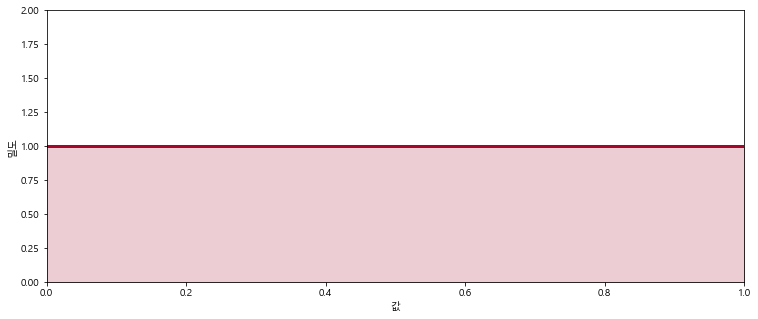

In [21]:
figsize(12.5, 5)
x = np.linspace(0.000, 1, 150)
y = np.linspace(1.0, 1.0, 150)
lines = plt.plot(x, y, color="#A60628", lw=3)
plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
plt.autoscale(tight=True)
plt.xlabel('값')
plt.ylabel('밀도')
plt.ylim(0, 2);

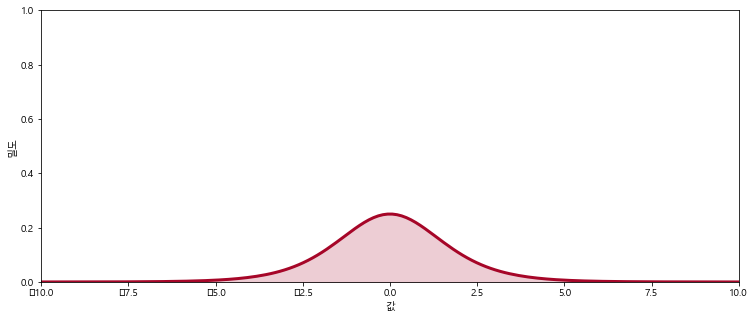

In [22]:
figsize(12.5, 5)
psi = np.linspace(-10, 10, 150)
y = np.exp(psi) / (1 + np.exp(psi))**2
lines = plt.plot(psi, y, color="#A60628", lw = 3)
plt.fill_between(psi, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.xlabel('값')
plt.ylabel('밀도')
plt.ylim(0, 1);

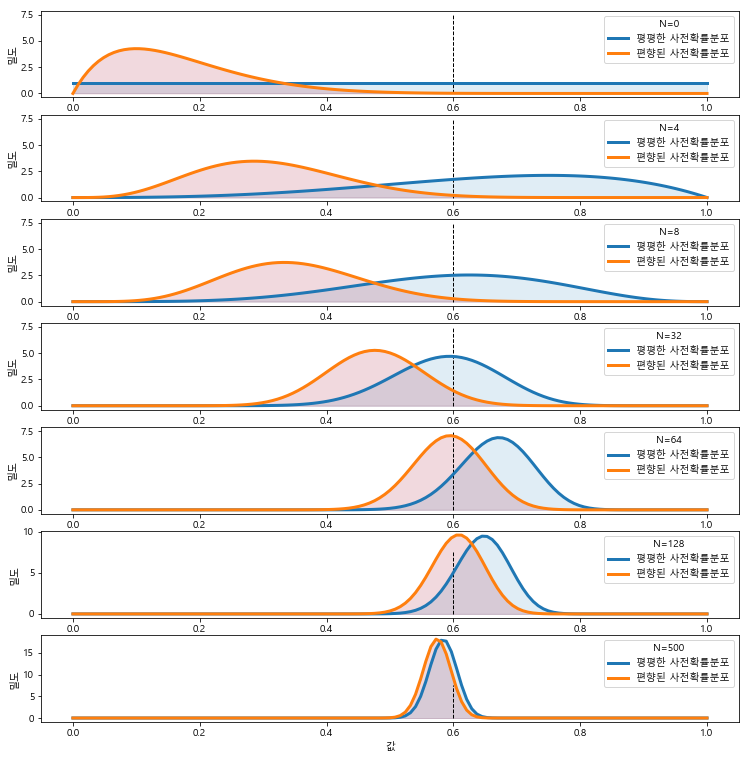

In [23]:
figsize(12.5, 15)

p = 0.6
beta1_params = np.array([1., 1.])
beta2_params = np.array([2, 10])
beta = stats.beta

x = np.linspace(0.00, 1, 125)
data = pm.rbernoulli(p, size=500)

plt.figure()
for i, N in enumerate([0, 4, 8, 32, 64, 128, 500]):
    s = data[:N].sum()
    plt.subplot(8, 1, i + 1)
    params1 = beta1_params + np.array([s, N - s])
    params2 = beta2_params + np.array([s, N - s])
    y1, y2 = beta.pdf(x, *params1), beta.pdf(x, *params2)
    plt.plot(x, y1, label=r"평평한 사전확률분포", lw=3)
    plt.plot(x, y2, label="편향된 사전확률분포", lw=3)
    plt.fill_between(x, 0, y1, color="#348ABD", alpha=0.15)
    plt.fill_between(x, 0, y2, color="#A60628", alpha=0.15)
    plt.legend(title="N=%d" % N)
    plt.vlines(p, 0.0, 7.5, linestyles="--", linewidth=1)
    plt.xlabel('값')
    plt.ylabel('밀도')
    #plt.title("더 많은 정보에 따른 사후확률분포(여러 사전 확률)의 수렴도")
    #plt.ylim( 0, 10)#


In [24]:
p_actual = 0.35
x = np.random.binomial(1, p_actual, size=100)
print (x[:10])

[1 0 1 0 1 0 1 0 0 0]


In [25]:
import pymc as pm
p = pm.Uniform('p', 0.5, 1)
obs = pm.Bernoulli('obs', p, value=x, observed=True)
mcmc = pm.MCMC([p, obs])
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.4 sec

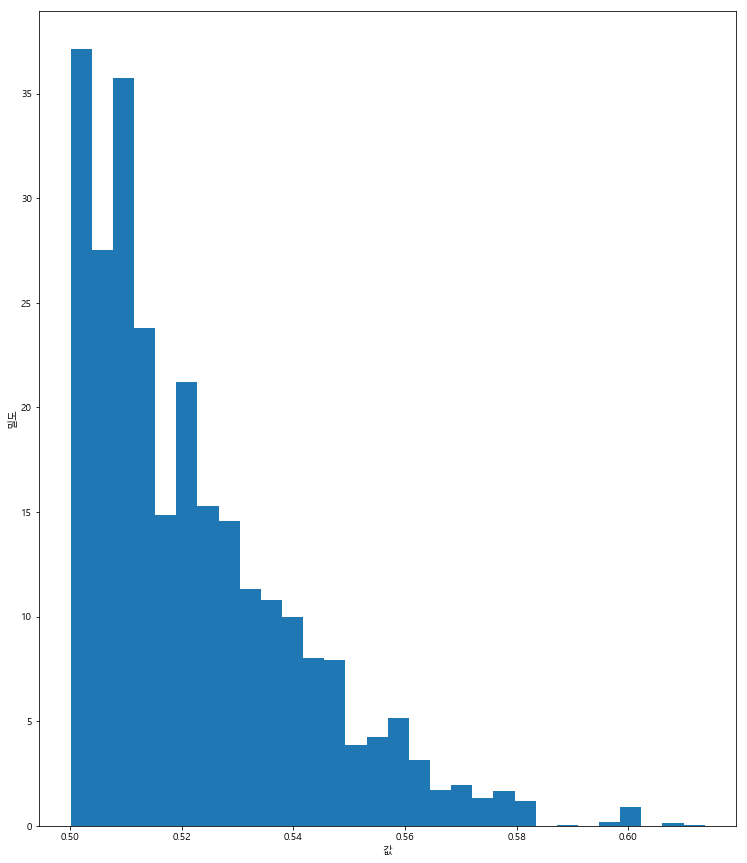

In [26]:
p_trace = mcmc.trace('p')[:]
plt.xlabel('값')
plt.ylabel('밀도')
plt.hist(p_trace, bins=30, histtype='stepfilled', normed=True);